**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

## Machine Learning Algorithms comparison: Support Vector Machine vs Random Forest

## Warning
Please, do not use the options to run all the cells together, because some cells contain the training methods for the algorithm and they require quite a long time to compute (usually more than 2 hours each). The results of the training are always included after these cells and before each cell of this type there is this warning:  

"The following cell contains the parameters tuning algorithm: do not execute it!"

### Abstract

This notebook analyzes two different machine learning algorithms and a deep neural network.
1. SVM - Support Vector Machine
2. RF - Random Forest

After a brief introduction, the given dataset will be presented and some methods to analyze and clean up the data will be introduced. Both algorithms use the same dataset and the same training approach. The model is, indeed, trained using the training data and their correspondent labels: the accuracy of the training is then calculated using the predicted labels and the training labels. Finally, the definitive predictions are exported to a CSV file in order to be uploaded to Kaggle.

### 1. Introduction

#### Support Vector Machine
Support Vector Machine is a supervised model used for classification and regression analysis. Each data point z is viewed as a p-dimensional array (in our case 264 features). The objective of the algorithm is to divide these points into a (p-1)-dimensional hyperplane. There are multiple possible choices for a hyperplane, but the best one, or the most reasonable one, is the one that guarantees the best margin between the classes or in other words, the one that is able to separate better the classes.
\[ Source: Wikipedia, https://en.wikipedia.org/wiki/Support_vector_machine \]

#### Random Forest
The Random Forest technique is an ensemble learning method for classification and regression. An ensemble method is a method that uses multiple learning algorithms to improve its performance. The algorithm creates a multitude of decision trees during the training phase and outputs the class that is the *mode* of all the classes (in classification) or mean prediction (in regression) of the individual trees.
\[ Source: Wikipedia, https://en.wikipedia.org/wiki/Random_forest ]


*mode*: the mode of a set of data is the value that appears the most and, therefore, it is the most likely to be sampled.

### 2. Data analysis

The provided data is split into two datasets, the training one and the testing one. In this case, only the labels corresponding to the training dataset are given.
This section will be focused on displaying and analyzing the provided data. In particular, there are plots of the datasets and the histogram that displays the distribution of the labels (the number of samples that correspond to each class).
The following cell imports the libraries needed throughout the notebook and loads the data sets (stored in CSV files).

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn import svm
import time


## Load files
test_data_accuracy = pd.read_csv('./accuracy/test_data.csv', header=None)
train_data_accuracy = pd.read_csv('./accuracy/train_data.csv', header=None)
train_labels_accuracy = pd.read_csv('./accuracy/train_labels.csv', header=None)

## Parse loaded content
test_data_accuracy = test_data_accuracy.values
train_data_accuracy = train_data_accuracy.values
train_labels_accuracy = train_labels_accuracy.values

## Check that the data was correctly loaded: 
## according to the document the correct shapes are 4363 x 264 for training data and 6544 x 264 for test data
assert train_data_accuracy.shape == (4363, 264)
assert test_data_accuracy.shape == (6544, 264)
## Obviously the train label should have a shape of 4363 x 1 (one label for each song in the training data set)
assert train_labels_accuracy.shape == (train_data_accuracy.shape[0], 1)

### Accuracy
This notebook starts with the accuracy challenge.

#### Table of contents
1. Data visualization
2. Data manipulation
3. ML Algorithm

### 1. Data visualiztion

*The commented code is valid code, feel free to utilize it. It was commented out because it is long to read and does not provide aggregate results. Moreover, this way the notebook runs faster (less computation to do)*

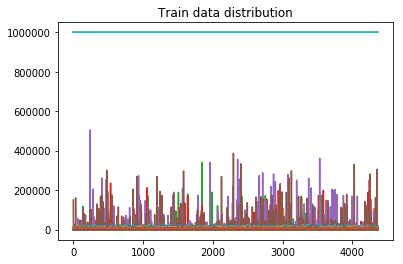

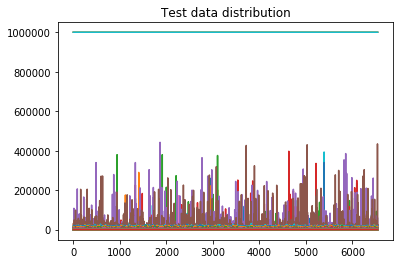

In [2]:
## Visualizes the training_data
plt.plot(train_data_accuracy)
plt.title('Train data distribution')
plt.show()
# mean = np.mean(train_data_accuracy, axis=0)
# std = np.std(train_data_accuracy, axis=0)
# for i in range(len(mean)):
#     print(f'{i}: the mean of the row is {mean[i]}, the variance is {std[i]}')
## Visualizes the test_data
plt.plot(test_data_accuracy)
plt.title('Test data distribution')
plt.show()
# mean = np.mean(test_data_accuracy, axis=0)
# std = np.std(test_data_accuracy, axis=0)
# for i in range(len(mean)):
#     print(f'{i}: the mean of the row is {mean[i]}, the variance is {std[i]}')

#### Observations
As we can see, neither the training data nor the test data are normalized. In addition to it, labels are not equally distributed, as almost 50% of the samples belong to class 1 (Pop_Rock). The figure below represents the occurrence (in %) of each label.

Label 1 (Pop_Rock): 49.92%
Label 2 (Electronic): 14.16%
Label 3 (Rap): 7.47%
Label 4 (Jazz): 5.8%
Label 5 (Latin): 4.9%
Label 6 (RnB): 5.96%
Label 7 (International): 3.23%
Label 8 (Country): 4.47%
Label 9 (Reggae): 2.11%
Label 10 (Blues): 1.97%


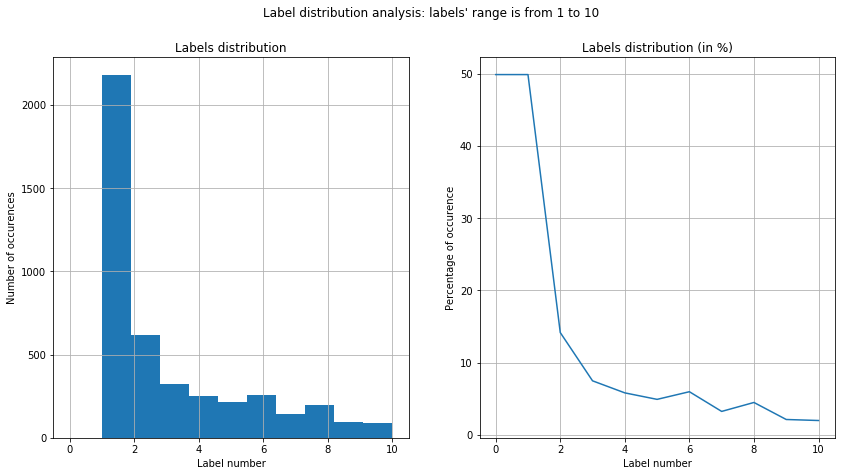

In [2]:
## Visualizes the labels
## Store the music genres that will be printed out
class_names = ['Pop_Rock', 'Electronic', 'Rap', 'Jazz', 'Latin', 'RnB', 'International', 'Country', 'Reggae', 'Blues']
data = np.empty((11, 2))
for i in range(1, 11, 1):
    print(f'Label {i} ({class_names[i - 1]}): {round((len(np.where(train_labels_accuracy == i)[0]) / len(train_labels_accuracy)) * 100, 2)}%')
    ## Since arrays are 0-indexed but the first label is 1, initialize the first position of the array using the first label (1)
    ## This is just to create a nice plot, does not have any effect on the algorithm.
    data[0, 0] = 0
    data[0, 1] = round((len(np.where(train_labels_accuracy == 1)[0]) / len(train_labels_accuracy)) * 100, 2)
    data[i, 0] = i
    data[i, 1] = round((len(np.where(train_labels_accuracy == i)[0]) / len(train_labels_accuracy)) * 100, 2)

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(14, 7))
ax = axs[0]
ax.hist(train_labels_accuracy)
ax.set_title('Labels distribution')
ax.set_xlabel('Label number')
ax.set_ylabel('Number of occurences')
ax.grid(True)

ax = axs[1]
ax.plot(data[:, 1])
ax.set_title('Labels distribution (in %)')
ax.set_xlabel('Label number')
ax.set_ylabel('Percentage of occurence')
ax.grid(True)


fig.suptitle('Label distribution analysis: labels\' range is from 1 to 10')
plt.show()

### 2. Data manipulation
#### Data Cleanup
From the plots at the previous section, it can be noticed that some columns (205 to 220) contain features whose values are not aligned with the others. Moreover, they seem to be the same for all the samples. When checking their exact values, one can corroborate that they are exactly the same throughout all the samples, so we can eliminate them from the training data as they will not provide any useful information when trying to classify the data.
*Now each sample, or song, has 248 features instead of 264.*

The result of this procedure can be seen at the comparison between the old dataset and the cleaned up dataset at the figures below.

**Note**: after various tests, it was discovered that eliminating the misaligned features had no practical effect on the whole algorithm. Indeed, even though the overall accuracy of the model slightly decreased (from 75.83% to 75.43%) the accuracy on the new data (test data) did not change. For this reason, have decided to use the complete dataset with all the features instead of the modified one.  
This is probably related to the approach that we decided to take in order to classify the samples. For example, when using a Neural Network if the classifier detects that some of the features are not meaningful to decide which class do the samples belong, the weights correspondent to that feature will be set to zero, having no impact on the decision.

*Feel free to transform the following cell to a code cell to try the algorithms using the resized data set.*

**Note**: since this notebook uses the scikit-learn library, it is suggested by the documentation to scale the data in order to obtain better results.
Scaled data has two particular characteristics:
- The mean value is almost equal to 0
- The variance is equal to 1

Thus, the data are centered around 0. The differences between the raw training data and the centered training data is visible at the plots below.
By using the StandardScaler() function it is possible to apply the same transformation to both datasets: training and testing.

The mean of the train data is: -3.9591392478315614e-17, the variance is: 0.9923953268977462
The mean of the test data is: -0.014540757008522483, the variance is: 1.0115121161980416


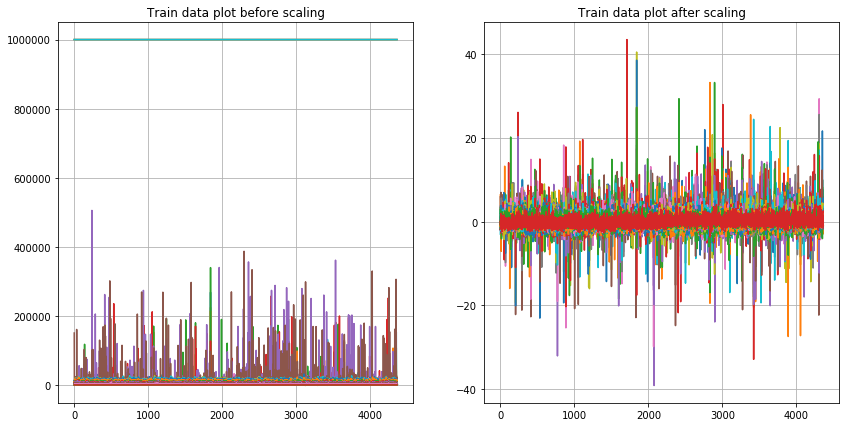

In [3]:
## Scales the data before feeding them into ML algorithms
scaler = preprocessing.StandardScaler().fit(train_data_accuracy)
train_data_scaled = scaler.transform(train_data_accuracy)   
test_data_scaled = scaler.transform(test_data_accuracy)                
print(f'The mean of the train data is: {np.mean(train_data_scaled)}, the variance is: {np.std(train_data_scaled)}')
print(f'The mean of the test data is: {np.mean(test_data_scaled)}, the variance is: {np.std(test_data_scaled)}')
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(14, 7))
ax = axs[0]
ax.plot(train_data_accuracy)
ax.set_title('Train data plot before scaling')
ax.grid(True)

ax = axs[1]
ax.plot(train_data_scaled)
ax.set_title('Train data plot after scaling')
ax.grid(True)

### 3. ML Algorithm
After cleaning up the data, it is time to implement the ML algorithms to predict the labels. For this purpose, this notebook uses *SVM - Support Vector Machine* and *RF - Random Forest*.
The notebook first starts with the SVM approach and ends with the implementation of the RF method.  
It is important to notice that both algorithms use the same data.

#### Parameters choice and hyperparameters tuning
In order to get the best results with SVM, the library allows the user to define several hyperparameters to fine tune the classifier. In order to find the best combination of those values, the following code has been used.
Mainly, the code creates a grid that will try all the combinations of the different parameters defined inside it. In our case, we have decided to tune the classifier trying different combinations between 'C', 'kernel' and 'gamma'.
The code will try all of the combinations and output all the hypervalues for the best classifier found.
**Important**: running the following cell require A LOT of time. The best set of parameters is reported in the next cell, so it is not necessary to run this cell again.

The following cell contains the algorithm that tunes the classifier: do not execute it!

#### Grid search results

In the following cell only a part of the data is displayed. The file accuracy-svm-tuning.csv contains all the data.

#### Best estimator:
The best classifier found combining the specified hypervalue parameters is:  
`SVC(C=3, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
 max_iter=-1, probability=False, random_state=None, shrinking=True, tol=0.001, verbose=True)`

#### Best parameters
The following cell contains the ML algorithm that uses the best set of parameters.

In [5]:
## Once we have the best parameters for the estimator, we can start predictions
clf = svm.SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001)
clf.fit(train_data_scaled, np.ravel(train_labels_accuracy))

SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Once we had a good idea of the optimal values for the classifier we tried to manually fine tune the SVM. Finally, we obtained the classifier below that performed even better than the previous one.

In [59]:
clf = svm.SVC(C=11, cache_size=400, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.00001)
clf.fit(train_data_scaled, np.ravel(train_labels_accuracy))

SVC(C=11, cache_size=400, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=1e-05, verbose=False)

Once we have our classifier, we can proceed to calculate the accuracy of the algorithm.

In [60]:
score = clf.score(train_data_scaled, train_labels_accuracy)
print(f'Algorithm accuracy is {np.round(score * 100, 2)}%')

Algorithm accuracy is 83.77%


The following cell displays the results obtained with the Support Vector Machine algorithm. The blue line represents the training labels and the red lines the predicted one. They should have a similar pattern, although if they were perfectly aligned it could be a sign of overfitting. When this happens, we might obtain great results (up to a 100% of accuracy) over the train data, but when trying with new data the algorithm has problems generalizing and the accuracy falls considerably.

Label 1 (Pop_Rock): 62.84%
Label 2 (Electronic): 13.72%
Label 3 (Rap): 7.64%
Label 4 (Jazz): 5.49%
Label 5 (Latin): 2.2%
Label 6 (RnB): 3.5%
Label 7 (International): 0.41%
Label 8 (Country): 2.38%
Label 9 (Reggae): 1.31%
Label 10 (Blues): 0.5%


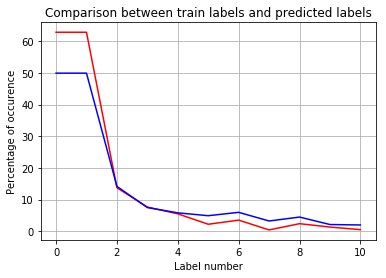

In [56]:
predictions = clf.predict(test_data_scaled)
data_p = np.empty((11, 2))
for i in range(1, 11, 1):
    print(f'Label {i} ({class_names[i - 1]}): {round((len(np.where(predictions == i)[0]) / len(predictions)) * 100, 2)}%')
    # Since arrays are 0-indexed but the first label is 1, initialize the first position of the array using the first label (1)
    # This is just to create a nice plot, does not have any effect on the algorithm.
    data_p[0, 0] = 0
    data_p[0, 1] = round((len(np.where(predictions == 1)[0]) / len(predictions)) * 100, 2)
    data_p[i, 0] = i
    data_p[i, 1] = round((len(np.where(predictions == i)[0]) / len(predictions)) * 100, 2)

plt.plot(data_p[:, 1], c='red')
plt.plot(data[:, 1], c='blue')
plt.grid(True)
plt.title('Comparison between train labels and predicted labels')
plt.xlabel('Label number')
plt.ylabel('Percentage of occurence')
plt.show()

The following cell is just a small utility function to save the predicted labels (contained in the 'pred' array) to a csv file that follows the specifications to be uploaded to Kaggle.

In [57]:
def save_prediction(pred, filename):
    prediction = pd.DataFrame(pred, columns=['Sample_label'])
    prediction.index += 1 
    prediction.to_csv(f'{filename}.csv',index_label="Sample_id",index=1)
    
save_prediction(predictions, 'SVM')

### RTF - Random Tree Forest

#### Tuning

The same way we did before with the SVM, the RTF object has many hyperparameters that allow the classifier to be optimized for each dataset. At the following cell, we perform the same grid search method in order to get an idea of the optimal values for the most important hyperparameters.
 
The best estimator found is presented in the next cell.
*The following cell takes about 93 minutes on jupyterhub to compute.*

The following cell contains the algorithm that tunes the classifier: do not execute it!

The best classifier found is:  
`{'n_estimators': 717, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 97, 'bootstrap': True}`

The Random Forest Classifier takes a lot of time to be computed.

Replace n_estimators=717 with n_estimators=100 to speed up the process (RandomForestClassifier with no tuning)

In [9]:
## Plug in the best parameters found
rtf = RandomForestClassifier(criterion='gini', n_estimators=717, min_samples_split=5, min_samples_leaf=4, max_features=None, max_depth=97, bootstrap=True)
rtf.fit(train_data_accuracy, np.ravel(train_labels_accuracy))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=97, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=717, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [10]:
score = rtf.score(train_data_accuracy, train_labels_accuracy)
print(f'Algorithm accuracy is {np.round(score * 100, 2)}%')

Algorithm accuracy is 94.55%


The following cell displays the results obatined with the RTF algorithm. Same way as before, the blue line represent the training labels and the red lines the predicted one.  

Label 1 (Pop_Rock): 75.15%
Label 2 (Electronic): 11.52%
Label 3 (Rap): 7.99%
Label 4 (Jazz): 2.19%
Label 5 (Latin): 0.84%
Label 6 (RnB): 1.76%
Label 7 (International): 0.0%
Label 8 (Country): 0.17%
Label 9 (Reggae): 0.35%
Label 10 (Blues): 0.03%


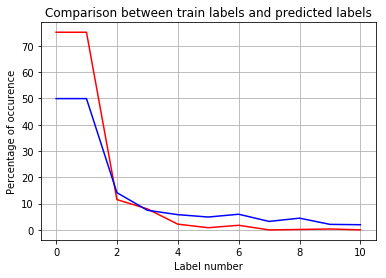

In [11]:
predictions = rtf.predict(test_data_accuracy)
data_p = np.empty((11, 2))
for i in range(1, 11, 1):
    print(f'Label {i} ({class_names[i - 1]}): {round((len(np.where(predictions == i)[0]) / len(predictions)) * 100, 2)}%')
    data_p[0, 0] = 0
    data_p[0, 1] = round((len(np.where(predictions == 1)[0]) / len(predictions)) * 100, 2)
    data_p[i, 0] = i
    data_p[i, 1] = round((len(np.where(predictions == i)[0]) / len(predictions)) * 100, 2)

plt.plot(data_p[:, 1], c='red')
plt.plot(data[:, 1], c='blue')
plt.grid(True)
plt.title('Comparison between train labels and predicted labels')
plt.xlabel('Label number')
plt.ylabel('Percentage of occurence')
plt.show()

## Export the calculated predictions
save_prediction(predictions, 'Tree')

### Bonus content: Neural Network
In this last section related to accuracy, the notebook contains the implementation of a Neural Network.
The Neural Network uses the MLPClassifier function from scikit-learn library. It is composed of two hidden layers of size ten each, plus one input and one output layer. Therefore, the final Neural Network has an initial layer composed by N-neurons, where N is the number of features of each sample, a second and a third layers of ten neurons, and finally an output layer of Z-neurons, where Z is the number of different classes.
In order to prevent the classifier to overfit, we use the early stop technique.
The algorithm tries to optimize the loss function in every epoch (maximum 1000 iterations) and stops when the loss does not improve more than 0.000001 for more than ten consecutive epochs.

In [12]:
from sklearn.neural_network import MLPClassifier

#### Parameters tuning
Again, the following cells evaluate which are the best parameters for the NN.

The best combination can be found below.

*Note*: running this cell takes a lot of time (more than 2 hours on our machine), so it is not advisable to run it. The correct parameters are already plugged in.

The following cell contains the parameters tuning algorithm: do not execute it!

Best parameters found:  
`{
    'activation': 'relu',
    'alpha': 0.0001,
    'early_stopping': True,
    'learning_rate': 'adaptive',
    'shuffle': False,
    'solver': 'adam'
}`

In [13]:
mlp = MLPClassifier(activation='relu',
                    alpha=0.0001,
                    hidden_layer_sizes=(264, 264, 110),
                    learning_rate='constant',
                    max_iter=1000,
                    shuffle=False,
                    solver='adam',
                    tol=0.000001,
                    verbose=True,
                    early_stopping=True
                    )
mlp.fit(train_data_scaled, np.ravel(train_labels_accuracy))

Iteration 1, loss = 1.53137948
Validation score: 0.588101
Iteration 2, loss = 1.16666515
Validation score: 0.606407
Iteration 3, loss = 1.01793104
Validation score: 0.624714
Iteration 4, loss = 0.89767324
Validation score: 0.636156
Iteration 5, loss = 0.79370006
Validation score: 0.631579
Iteration 6, loss = 0.72271860
Validation score: 0.638444
Iteration 7, loss = 0.63216316
Validation score: 0.652174
Iteration 8, loss = 0.51658349
Validation score: 0.638444
Iteration 9, loss = 0.43148417
Validation score: 0.652174
Iteration 10, loss = 0.35609656
Validation score: 0.633867
Iteration 11, loss = 0.28690197
Validation score: 0.656751
Iteration 12, loss = 0.22698770
Validation score: 0.647597
Iteration 13, loss = 0.17703359
Validation score: 0.640732
Iteration 14, loss = 0.13894205
Validation score: 0.661327
Iteration 15, loss = 0.10276136
Validation score: 0.647597
Iteration 16, loss = 0.07970532
Validation score: 0.636156
Iteration 17, loss = 0.05502188
Validation score: 0.638444
Iterat

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(264, 264, 110), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=False, solver='adam', tol=1e-06,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [14]:
score = mlp.score(train_data_scaled, train_labels_accuracy)
print(f'Algorithm accuracy is {np.round(score * 100, 2)}%')

Algorithm accuracy is 96.63%


The following cell displays the results achieved with the Neural Network algorithm. As always, the blue line represent the training labels and the red lines the predicted one.

Label 1 (Pop_Rock): 55.81%
Label 2 (Electronic): 12.94%
Label 3 (Rap): 7.27%
Label 4 (Jazz): 6.65%
Label 5 (Latin): 3.99%
Label 6 (RnB): 5.42%
Label 7 (International): 1.74%
Label 8 (Country): 3.24%
Label 9 (Reggae): 1.64%
Label 10 (Blues): 1.3%


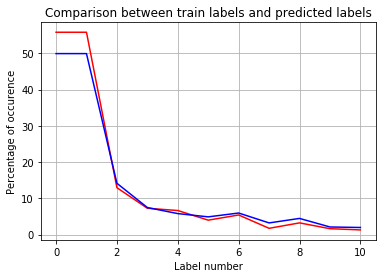

In [15]:
predictions = mlp.predict(test_data_scaled)
data_p = np.empty((11, 2))
for i in range(1, 11, 1):
    print(f'Label {i} ({class_names[i - 1]}): {round((len(np.where(predictions == i)[0]) / len(predictions)) * 100, 2)}%')
    data_p[0, 0] = 0
    data_p[0, 1] = round((len(np.where(predictions == 1)[0]) / len(predictions)) * 100, 2)
    data_p[i, 0] = i
    data_p[i, 1] = round((len(np.where(predictions == i)[0]) / len(predictions)) * 100, 2)

plt.plot(data_p[:, 1], c='red')
plt.plot(data[:, 1], c='blue')
plt.grid(True)
plt.title('Comparison between train labels and predicted labels')
plt.xlabel('Label number')
plt.ylabel('Percentage of occurence')
plt.show()

save_prediction(predictions, 'NN')

## Log-loss
After the accuracy challenge, this section is focused on the other challenge, the log-loss.  
Data visualization and manipulation sections are the same as above, so will not be commented.  

For the log-loss challenge, only the SVM algorithm has been used, since the Neural Network did not perform well during tests (its loss on Kaggle was 0.68353), obtaining a loss approximately 6 times worse than the SVM one. However, as in the previous challenge, the two versions of SVM are compared (with and without hyperparameters tuning).

### Contents
1. Data visualization: how are the raw data provided?
2. Data manipulation
3. ML Algorithm

In [32]:
# Libraries are already imported

# Loads the files
test_data_logloss = pd.read_csv('./log-loss/test_data.csv', header=None)
train_data_logloss = pd.read_csv('./log-loss/train_data.csv', header=None)
train_labels_logloss = pd.read_csv('./log-loss/train_labels.csv', header=None)

# Parse loaded content
test_data_logloss = test_data_logloss.values
train_data_logloss = train_data_logloss.values
train_labels_logloss = train_labels_logloss.values

### 1. Data visualization

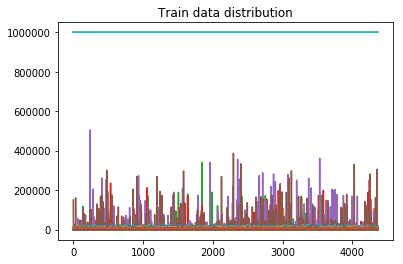

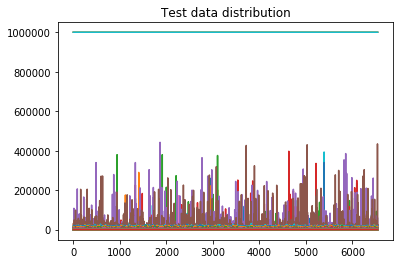

In [17]:
## Visualizes the training_data
plt.plot(train_data_logloss)
plt.title('Train data distribution')
plt.show()
# mean = np.mean(train_data_logloss, axis=0)
# std = np.std(train_data_logloss, axis=0)
# for i in range(len(mean)):
#     print(f'{i}: the mean of the row is {mean[i]}, the variance is {std[i]}')
## Visualizes the test_data
plt.plot(test_data_logloss)
plt.title('Test data distribution')
plt.show()
# mean = np.mean(test_data_logloss, axis=0)
# std = np.std(test_data_logloss, axis=0)
# for i in range(len(mean)):
#     print(f'{i}: the mean of the row is {mean[i]}, the variance is {std[i]}')

#### Observations
As we can see the training data nor the test data are normalized. In addition to it, labels are not equally distribuited: indeed there are more label of class 1 (almost 50%), Pop_Rock, then any other classes as we can see in the cell below. The figure below represents the occurence (in %) of each label.

Label 1 (Pop_Rock): 49.92%
Label 2 (Electronic): 14.16%
Label 3 (Rap): 7.47%
Label 4 (Jazz): 5.8%
Label 5 (Latin): 4.9%
Label 6 (RnB): 5.96%
Label 7 (International): 3.23%
Label 8 (Country): 4.47%
Label 9 (Reggae): 2.11%
Label 10 (Blues): 1.97%


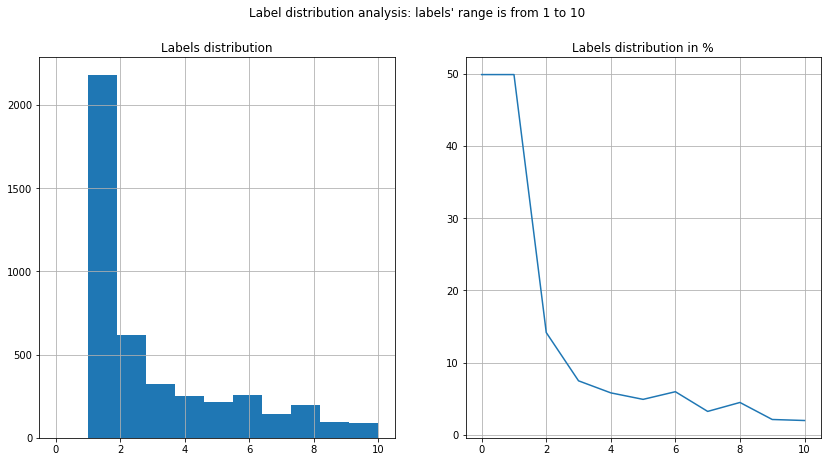

In [33]:
# Visualizes the labels
class_names = ['Pop_Rock', 'Electronic', 'Rap', 'Jazz', 'Latin', 'RnB', 'International', 'Country', 'Reggae', 'Blues']
# Since labels start by 1, in the first position of the data array, I inserted again the value of the first label, to obtain a decent plot
data = np.empty((11, 2))
for i in range(1, 11, 1):
    print(f'Label {i} ({class_names[i - 1]}): {round((len(np.where(train_labels_logloss == i)[0]) / len(train_labels_logloss)) * 100, 2)}%')
    data[0, 0] = 0
    data[0, 1] = round((len(np.where(train_labels_logloss == 1)[0]) / len(train_labels_logloss)) * 100, 2)
    data[i, 0] = i
    data[i, 1] = round((len(np.where(train_labels_logloss == i)[0]) / len(train_labels_logloss)) * 100, 2)

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(14, 7))
ax = axs[0]
ax.hist(train_labels_logloss)
ax.set_title('Labels distribution')
ax.grid(True)

ax = axs[1]
ax.plot(data[:, 1])
ax.set_title('Labels distribution in %')
ax.grid(True)

fig.suptitle('Label distribution analysis: labels\' range is from 1 to 10')
plt.show()

### 2. Data manipulation

The mean of the train data is: -3.9591392478315614e-17, the variance is 0.9923953268977462
The mean of the test data is: -0.014540757008522483, the variance is 1.0115121161980416


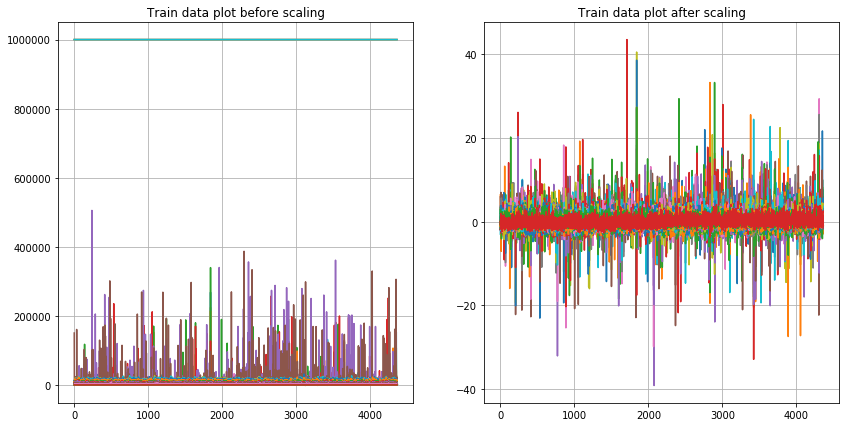

In [34]:
# Scales the data before feeding them into ML algorithms
scaler = preprocessing.StandardScaler().fit(train_data_logloss)
train_data_scaled = scaler.transform(train_data_logloss)   
test_data_scaled = scaler.transform(test_data_logloss)                
print(f'The mean of the train data is: {np.mean(train_data_scaled)}, the variance is {np.std(train_data_scaled)}')
print(f'The mean of the test data is: {np.mean(test_data_scaled)}, the variance is {np.std(test_data_scaled)}')
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(14, 7))
ax = axs[0]
ax.plot(train_data_accuracy)
ax.set_title('Train data plot before scaling')
ax.grid(True)

ax = axs[1]
ax.plot(train_data_scaled)
ax.set_title('Train data plot after scaling')
ax.grid(True)

### 3. ML Algorithm
After data cleanup, the code used to predict the labels with the Support Vector Machine classifier can be found in the cells below.

The following cell contains the parameters tuning algorithm: do not execute it!

#### Grid search results

In the following cell only a part of the data is displayed. The file log-loss-svm-tuning.csv contains all the data.

The best estimator is:
`SVC(
    C=3,
    cache_size=200,
    class_weight=None,
    coef0=0.0,
    decision_function_shape='ovr',
    degree=3, 
    gamma='auto',
    kernel='rbf',
    max_iter=-1,
    probability=True, 
    random_state=None,
    shrinking=True,
    tol=0.001, 
    verbose=True
 )`

In [6]:
clf = svm.SVC(
    C=3,
    cache_size=200,
    class_weight=None,
    coef0=0.0,
    decision_function_shape='ovr',
    degree=3, 
    gamma='auto',
    kernel='rbf',
    max_iter=-1,
    probability=True, 
    random_state=None,
    shrinking=True,
    tol=0.001, 
    verbose=True
)
clf.fit(train_data_scaled, np.ravel(train_labels_logloss))

[LibSVM]

SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

The same it was done previously, once we have a starting point for the optimal values, we can fine tune the classifier manually obtaining:

In [45]:
clf = svm.SVC(C=10, cache_size=400, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.00001)
clf.fit(train_data_scaled, np.ravel(train_labels_logloss))

SVC(C=11, cache_size=400, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=1e-05, verbose=False)

In [46]:
score = clf.score(train_data_scaled, train_labels_logloss)
print(f'Algorithm accuracy is {np.round(score * 100, 2)}%')

Algorithm accuracy is 83.77%


Average probability for label 1 (Pop_Rock): 49.45%
Average probability for label 2 (Electronic): 14.2%
Average probability for label 3 (Rap): 7.23%
Average probability for label 4 (Jazz): 6.07%
Average probability for label 5 (Latin): 5.12%
Average probability for label 6 (RnB): 5.56%
Average probability for label 7 (International): 3.81%
Average probability for label 8 (Country): 4.26%
Average probability for label 9 (Reggae): 1.99%
Average probability for label 10 (Blues): 2.31%


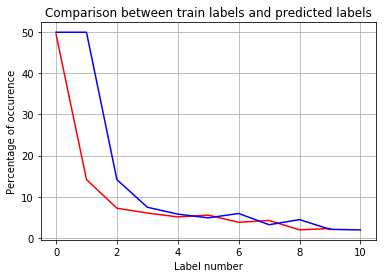

In [47]:
predictions = clf.predict_proba(test_data_scaled)
assert predictions.shape == (6544, 10)

data_l = np.empty((1, 10))
for i in range(predictions.shape[1]):
    data_l[0, i] = np.mean(predictions[:, i]) * 100
    print(f'Average probability for label {i + 1} ({class_names[i]}): {np.round(data_l[0, i], 2)}%')

plt.plot(data_l[0, :], c='red')
plt.plot(data[:, 1], c='blue')
plt.grid(True)
plt.title('Comparison between train labels and predicted labels')
plt.xlabel('Label number')
plt.ylabel('Percentage of occurence')
plt.show()

In [49]:
def save_prediction_loss(loss):
    prediction = pd.DataFrame(loss,columns=['Class_1','Class_2','Class_3','Class_4','Class_5',
                                            'Class_6','Class_7','Class_8','Class_9','Class_10'])
    prediction.index += 1 
    prediction.to_csv('loss_kaggle.csv',index_label="Sample_id",index=1)
    
save_prediction_loss(predictions)

## 4. Results

As an overview, these are the results we obtained on Kaggle:  
### Accuracy challenge
- SVM with hyperparameter tuning: 0.66123
- SVM without hyperparameter tuning: 0.64034
- RF with hyperparameter tuning: 0.61691
- RF without hyperparameter tuning: 0.64034
- NN with hyperparameter tuning: 0.62608
- NN without hyperparameter tuning: 0.63728

### Logloss challenge
- SVM with hyperparameter tuning: 0.16761
- SVM without hyperparameter tuning: 0.16922 

## 5. Discussion/Conclusions

This paper analyzed different approaches in order to solve the same problem: music genre classification.
The most accurate algorithm was the Support Vector Machine with hyperparameters tuning: it was possible to achieve an accuracy of 66.123% over the test data. 
On the other hand, the Random Forest algorithm performed quite well as well without any kind of tuning (64.03%), but became less accurate when we tried to optimize its parameters.
In order to optimize the parameters, two different approaches were used:
1. GridSearchCV
2. RandomizedSearchCV  

These two strategies apply the same algorithm in two different methods:  
GridSearchCV evaluates the accuracy and other statistics of a ML method by trying all the possible combinations between the parameters and the values specified in the grid. For this reason, it is computationally expensive and takes a long time to complete.

RandomizedSearchCV, on the other hand, operates by choosing random combinations of parameters and picking the best one. This method is faster since the number of iterations can be limited, but sometimes is less accurate. This second is useful when not having any idea on which values could be the optimal ones, as the GridSearchCV is more useful when we already have an idea where the optimal values could be found.

GridSearchCV was used to tune the SVM estimator since it has fewer parameters and it was possible to compute the best estimator in a relatively small amount of time (less than 2 hours). 

RandomizedSearchCV was instead used to tune the parameters of RT because it contains more parameters and thus more possible combination. Indeed, applying the GridSearchCV resulted in having to evaluate more than 25 thousand scores. While we were able to optimize it performing only 50 fits with the randomized search.

Finally, the Neural Network did not benefit from the hyperparameters tuning.  

The infectivity of the tuning for Random Forest and for Neural Networks might be caused by the fact that, while for SVM is possible to test more parameters that have some more common values (for example gamma is usually a value less than 1 or is 'auto' or 'scale'), the RF and the Neural Network both rely heavily on the number of the estimators (for the RF) or layers (e.g. perceptrons per layer) for the Neural Network. This factor difficulted the task of finding the best combination and it requires significantly more time.

## 6. References

All the references used throughout the notebook can be found reported at the bottom of this cell.   
However, instead of using the standard IEEE reference style, the references were put inline in the text for an easier and faster access.

Wikipedia, https://en.wikipedia.org/wiki/Support_vector_machine  
Wikipedia, https://en.wikipedia.org/wiki/Random_forest
